In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [ ]:
def generate_sequence(c=0.005, f_0=0):
    """
    Generate a linear chirp signal. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 0.1)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f

In [12]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        # Input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

        self.initialize_weights()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h_next = self.activation(self.i2h(combined))
        output = self.h2o(h_next)
        return output, h_next

    def initialize_weights(self):
        for layer in [self.i2h, self.h2o]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

In [14]:
num_epochs = 100
hidden_size = 8
criterion = nn.MSELoss()

In [15]:
X, Y = generate_sequence()

In [ ]:
def run_one_step(t, train=True):
    """
    We train an RNN to predict the instantaneous frequency in the future, given the time-domain value and the previous state.

    When train == True: 
        The RNN is trained on the first t steps of the sequence and evaluated on the future steps

    When train == False
        The RNN is not trained at all (no gradient steps)    
    """

    # initialize
    set_seed(1996)
    rnn = RNNCell(1, hidden_size, 1)
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

    # train
    if train:
        input_seq, output_seq = X[:t], Y[:t]
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            h = torch.zeros(1, hidden_size)
            loss = 0.0
            for k in range(t):
                x = torch.tensor(input_seq[k]).view(1, -1).float()
                y = torch.tensor(output_seq[k]).view(1).float()
                out, h = rnn(x, h)
                loss += criterion(out.view(1), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()/t:.4f}")

    # evaluate
    input_seq, output_seq = X, Y
    with torch.no_grad():
        h = torch.zeros(1, hidden_size)
        loss = []
        for k in range(len(X)):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            if k >= t:
                loss.append(((out.view(1) - y)**2).item())
    error = np.mean(loss)
    return error

In [17]:
t_list = np.arange(10, 400+1, 50)
err_1_list = []
err_2_list = []
for t in t_list:
    err = run_one_step(t, train=True)
    err_1_list.append(err)

    err = run_one_step(t, train=False)
    err_2_list.append(err)

Epoch 100/100, Loss: 0.0038: 100%|██████████| 100/100 [00:03<00:00, 28.90it/s]


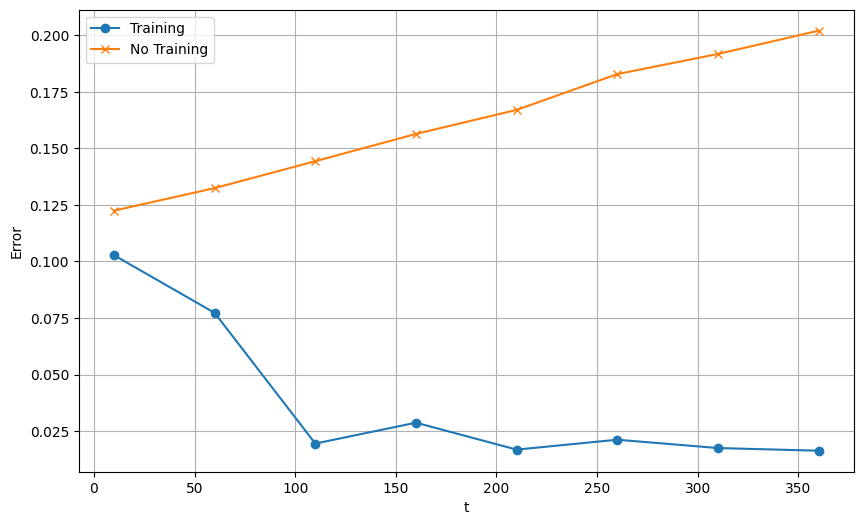

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, err_1_list, label='Training', marker='o')
plt.plot(t_list, err_2_list, label='No Training', marker='x')
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()